# Day2

## Step1. 만들고자 하는 구조를 미리 정의
- 데이터
- 훈련
- 평가

# LeNet-5 구현

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow import keras

## 데이터

In [2]:
data = tf.keras.datasets.mnist.load_data()

In [3]:
?tf.keras.datasets.mnist.load_data

Signature: tf.keras.datasets.mnist.load_data(path='mnist.npz')
Docstring:
Loads the MNIST dataset.

This is a dataset of 60,000 28x28 grayscale images of the 10 digits,
along with a test set of 10,000 images.
More info can be found at the
[MNIST homepage](http://yann.lecun.com/exdb/mnist/).

Args:
  path: path where to cache the dataset locally
    (relative to `~/.keras/datasets`).

Returns:
  Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

**x_train**: uint8 NumPy array of grayscale image data with shapes
  `(60000, 28, 28)`, containing the training data. Pixel values range
  from 0 to 255.

**y_train**: uint8 NumPy array of digit labels (integers in range 0-9)
  with shape `(60000,)` for the training data.

**x_test**: uint8 NumPy array of grayscale image data with shapes
  (10000, 28, 28), containing the test data. Pixel values range
  from 0 to 255.

**y_test**: uint8 NumPy array of digit labels (integers in range 0-9)
  with shape `(10000,)` for the test data.

Ex

In [4]:
(train_X, train_y), (test_X, test_y) = data

In [5]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [6]:
train_X = train_X.reshape((-1, 28, 28, 1))
test_X = test_X.reshape((-1, 28, 28, 1))

In [7]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [8]:
from sklearn.model_selection import train_test_split

train_X,valid_x,train_y,valid_y=train_test_split(train_X,train_y,test_size=0.2)

train_X=train_X/255.0
valid_x=valid_x/255.0
test_X=test_X/255.0

## 훈련

### 합성곱

In [9]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

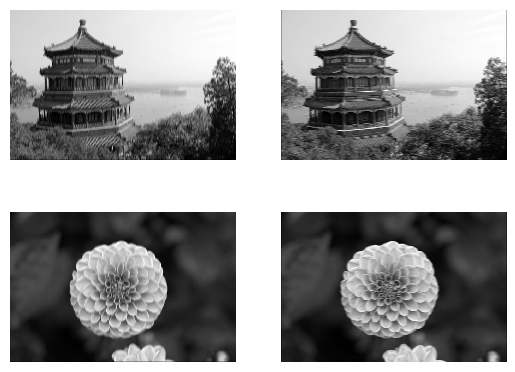

In [10]:
import numpy as np
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 2개의 필터를 만듭니다.
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직선
filters[3, :, :, 1] = 1  # 수평선

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

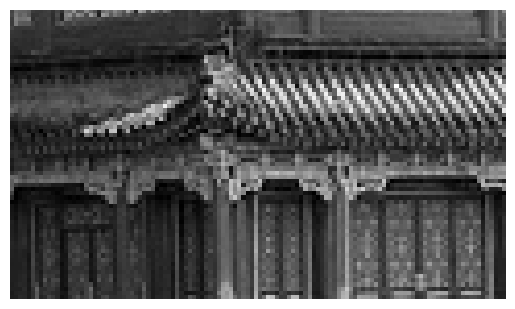

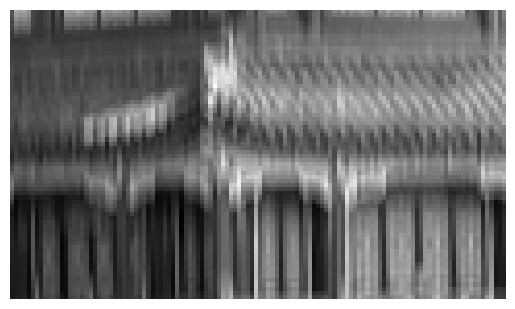

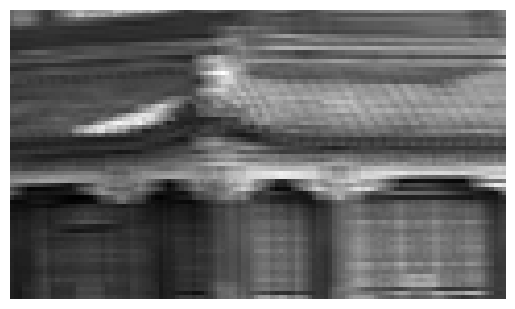

In [11]:
def crop(images):
    return images[150:220, 130:250]
plot_image(crop(images[0, :, :, 0]))
plt.show()
for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

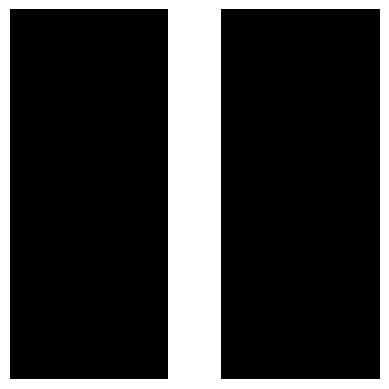

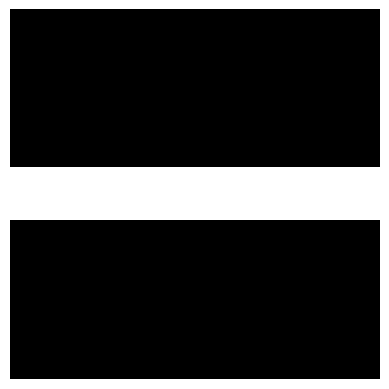

In [12]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [13]:
np.random.seed(42)
tf.random.set_seed(42)
conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1, padding="SAME", activation="relu", input_shape=outputs.shape)
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

- 필터는 초기에 랜덤하게 초기화되기 때문에 처음에는 랜덤한 패턴을 감지합니다. 필터가 초기에 랜덤하게 초기화되엇지만 두 번째 필터는 에지를 감지한 것처럼 보입니다. 랜덤하게 초기화된 필터는 종종 이런 식으로 동작합니다. 에지 감지는 이미지 처리에 매우 유용하기 때문에 운이 좋습니다. 원한다면 필터를 앞에서 수동으로 정의한 필터를 사용하고 편향을 0으로 지정할 수 있습니다(합성곱 층이 훈련하는 동안 적절한 필터와 편향을 학습하기 때문에 실제로는 수동으로 필터와 편향을 지정할 필요가 거의 없습니다)
- 출력은 4D 텐서입니다. 차원은 배치 크기, 높이, 너비, 채널입니다. 2개의 이미지를 입력으로 사용했기 때문에 첫 번째 차원(배치 크기)는 2입니다. 다음 두 차원은 출력 특성맵의 높이와 너비입니다. padding="SAME"와 strides=1로 설정했기 때문에 출력 특성맵의 높이와 너비는 입력 이미지와 같습니다(이 경우 427×640). 마지막으로 이 합성곱 층은 2개의 필터를 사용합니다. 따라서 마지막 차원의 크기는 2입니다. 즉 입력 이미지마다 2개의 특성맵이 출력됩니다.

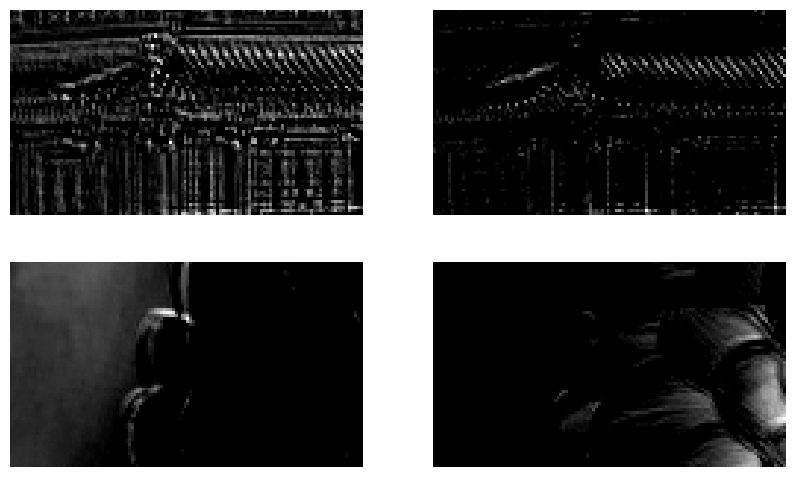

In [14]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [15]:
conv.set_weights([filters, np.zeros(2)])
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

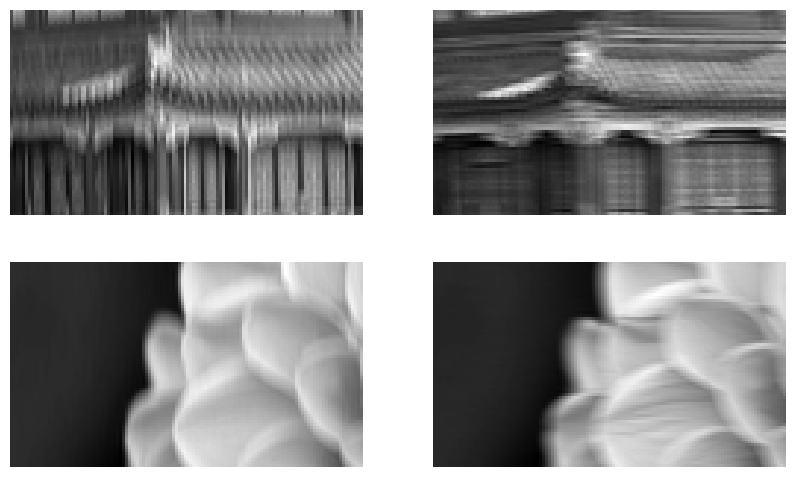

In [16]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

### 폴링

#### 최대

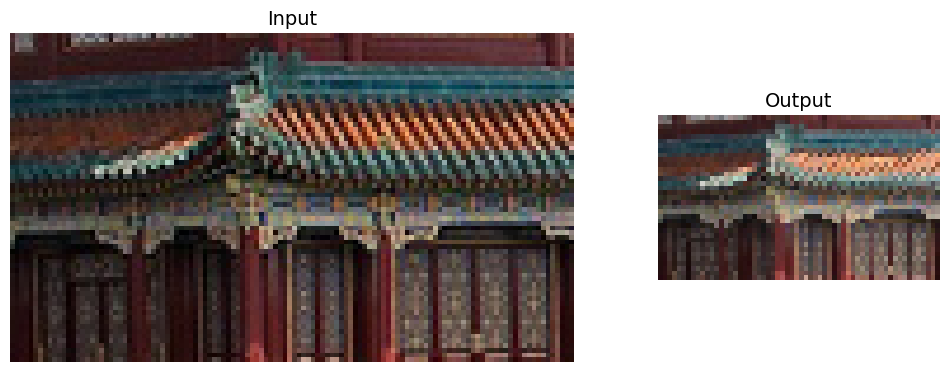

In [17]:
max_pool = keras.layers.MaxPool2D(pool_size=2) # 2 by 2
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")
plt.show()

#### 평균

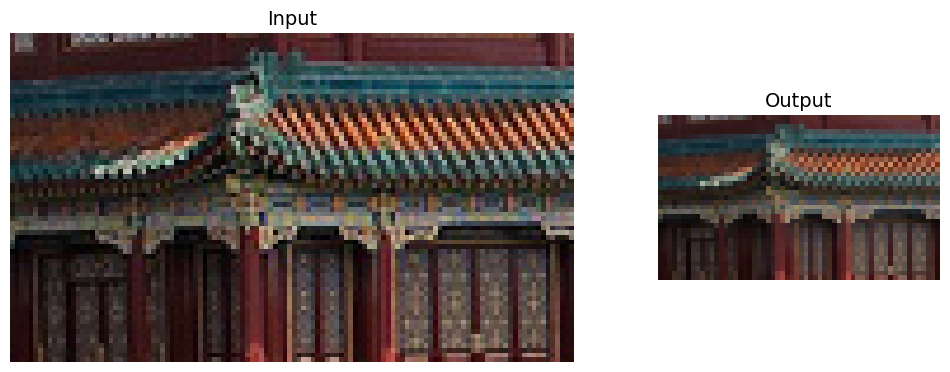

In [18]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, AveragePooling2D, Flatten, Dense, ZeroPadding2D

In [29]:
class LeNet(Sequential):
  def __init__(self,num_classes):
    super().__init__()
    self.add(Conv2D(6,5,strides=1,activation='tanh',input_shape=(28,28,1),padding='same'))
    # 6 * (1 * 5 * 5 + 1)
    self.add(AveragePooling2D(2,strides=2))
    self.add(Conv2D(16,5,strides=1,activation='tanh'))
    # 16 * (6 * 5 * 5 + 1)
    self.add(AveragePooling2D(2,strides=2))
    self.add(Conv2D(120,5,strides=1,activation='tanh'))
    # 120 * (16 * 5 * 5 + 1)
    self.add(Flatten())
    self.add(Dense(84,activation='tanh'))
    # 84 * (120+1)
    self.add(Dense(num_classes,activation='softmax'))
    # 10 * (84+1)
    self.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [30]:
model=LeNet(10)
model.summary()

Model: "le_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_5 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_6 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten_2 (Flatten)         (None, 120)               0  

In [31]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history=model.fit(train_X,train_y, epochs=20, validation_data=(valid_x,valid_y), callbacks=[early_stopping_cb],)

Epoch 1/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2619 - accuracy: 0.9216 - val_loss: 0.1332 - val_accuracy: 0.9584
Epoch 2/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1019 - accuracy: 0.9693 - val_loss: 0.0873 - val_accuracy: 0.9747
Epoch 3/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0672 - accuracy: 0.9788 - val_loss: 0.0725 - val_accuracy: 0.9780
Epoch 4/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0506 - accuracy: 0.9841 - val_loss: 0.0624 - val_accuracy: 0.9817
Epoch 5/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0408 - accuracy: 0.9870 - val_loss: 0.0611 - val_accuracy: 0.9812
Epoch 6/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0326 - accuracy: 0.9895 - val_loss: 0.0548 - val_accuracy: 0.9843
Epoch 7/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0276 - accuracy: 0.9909 - val_loss: 0.0579 - val_accuracy:

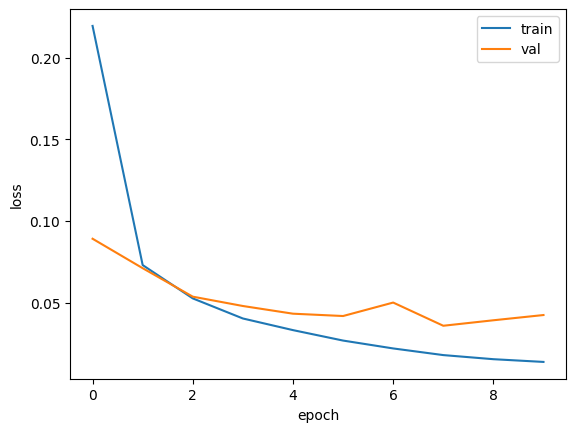

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

## 평가

In [32]:
model.evaluate(test_X, test_y)

313/313 [==============================] - 1s 2ms/step - loss: 0.0471 - accuracy: 0.9858


[0.047083545476198196, 0.98580002784729]

In [26]:
?model.evaluate

Signature:
model.evaluate(
    x=None,
    y=None,
    batch_size=None,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
    **kwargs,
)
Docstring:
Returns the loss value & metrics values for the model in test mode.

Computation is done in batches (see the `batch_size` arg.)

Args:
    x: Input data. It could be:
      - A Numpy array (or array-like), or a list of arrays
        (in case the model has multiple inputs).
      - A TensorFlow tensor, or a list of tensors
        (in case the model has multiple inputs).
      - A dict mapping input names to the corresponding array/tensors,
        if the model has named inputs.
      - A `tf.data` dataset. Should return a tuple
        of either `(inputs, targets)` or
        `(inputs, targets, sample_weights)`.
      - A generator or `keras.utils.Sequence` returning `(inputs,
        targets)` or `(inputs, targets, sa